In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from skipper import observe

import sys
sys.path.append('../scripts/')
import our_pointings
import sigjson_f2024b

halpha_pointings, oiii_pointings =  our_pointings.load_fallfields()
fields = oiii_pointings['object'].str.extract(r'(.*?(?=_))')[0]

import importlib
importlib.reload(sigjson_f2024b)
obsdates = sigjson_f2024b.obsdates
obsfilters = sigjson_f2024b.obsfilters

In [22]:
copilot_fname = '/Users/kadofong/Downloads/db_merian.fits'
tele_fname = '/Users/kadofong/Downloads/tele20240410.csv'

coo_o = observe.CopilotOutput ( copilot_fname, oiii_pointings, )
coo_h = observe.CopilotOutput ( copilot_fname, halpha_pointings )

# Check Moon

In [6]:
ctio = observe.ObservingSite ()

In [7]:
moonarr = np.zeros([len(obsdates),2])
for idx in range(len(moonarr)):
    year, month, day = obsdates[idx][:3]
    slot = obsdates[idx,-2]
    night_start, night_end = ctio.get_sunriseset ( year, month, day, cut_at_contract=False )
    midpoint = night_start + 0.5*(night_end-night_start)
    if slot == 0:
        obs_start = night_start
        obs_end = night_end
    elif slot == 1:
        #print('[predict] night slot: First half')
        obs_start = night_start
        obs_end = midpoint
    elif slot==2:
        #print('[predict] night slot: Second half')
        obs_start = midpoint
        obs_end = night_end 
    elif slot==3:
        #print('[predict] night slot: Second 3/4')
        obs_start = night_start + 0.5*(midpoint - night_start)
        obs_end = night_end
    elif slot==4:
        if extra == 1:
            s = ''
        else:
            s = 's'
        #print (f'[predict] night slot: Second half and the last {extra} hour{s} of the first half')
        obs_start = midpoint - datetime.timedelta(hours=extra)
        obs_end = night_end
    moon_cillum, moon_altreport = ctio.track_moon ( obs_start, obs_end )
    moonarr[idx] = (moon_cillum, moon_altreport)
    print ( f'On {year}/{month:02d}/{day:02d}: {obsfilters[idx]} + MOON {moon_cillum*100:.0f}pct' )

[observe] Computing sunrise and sunset on 2024/8/2 at altitude = -14.0


        Use get_body("moon") instead. [skipper.observe]
        Use get_body("moon") instead. [skipper.astroplan_moon]


On 2024/08/02: N540 + MOON 2pct
[observe] Computing sunrise and sunset on 2024/8/6 at altitude = -14.0
On 2024/08/06: N540 + MOON 8pct
[observe] Computing sunrise and sunset on 2024/8/7 at altitude = -14.0
On 2024/08/07: N540 + MOON 13pct
[observe] Computing sunrise and sunset on 2024/8/8 at altitude = -14.0
On 2024/08/08: N540 + MOON 20pct
[observe] Computing sunrise and sunset on 2024/8/10 at altitude = -14.0
On 2024/08/10: N708 + MOON 37pct
[observe] Computing sunrise and sunset on 2024/8/11 at altitude = -14.0
On 2024/08/11: N708 + MOON 47pct


Text(0, 0.5, 'moon illumination fraction')

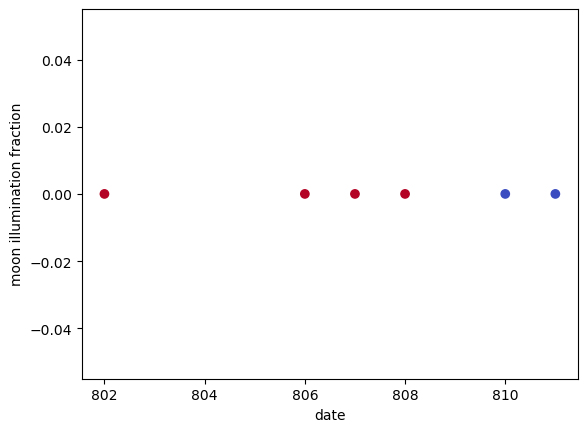

In [8]:
indices = obsdates[:,1]*100+obsdates[:,2]

mooneff = np.where(moonarr[:,1]>0, moonarr[:,0], 0.)


plt.scatter (indices[:], mooneff[:], c=obsfilters[:]=='N540', cmap='coolwarm' )
plt.xlabel('date')
plt.ylabel('moon illumination fraction')

# Assume "Perfect" (no overheads, no weather) performance

In [44]:
from astropy.io import fits
from astropy import table

In [45]:
ppointings = table.Table(fits.getdata('../pointings/high_priority/N708_pointing_list_fall_2024.fits',1))

In [56]:
np.in1d(halpha_pointings['object'], ppointings['object'])

array([ True, False, False, False,  True,  True,  True, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False,  True,  True, False, False,  True,  True,
       False, False, False, False, False,  True, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True, False,

In [31]:
is_queued_oiii = None
is_queued_halpha = None

halpha_emptyhours = []
oiii_emptyhours = []

for idx in range(len(obsdates)):
    night = obsdates[idx]
    mfilt = obsfilters[idx]
    if mfilt == 'N540':
        is_queued_oiii, emptyhours = sigjson_f2024b.plan_tomorrow( night[2], night[1], night[0], 
                                                 tele_fname, 
                                                 copilot_fname, 
                                                 slot = night[3],
                                                 mfilt=mfilt, 
                                                 is_queued=is_queued_oiii, 
                                                 pad_last_hour=False, 
                                                 maxairmass=2., 
                                                 save=False, 
                                                 verbose=False)
    else:
        is_queued_halpha, emptyhours = sigjson_f2024b.plan_tomorrow( night[2], night[1], night[0], 
                                                 tele_fname, 
                                                 copilot_fname, 
                                                 slot = night[3],
                                                 mfilt=mfilt, 
                                                 is_queued=is_queued_halpha, 
                                                 pad_last_hour=False, 
                                                 maxairmass=2., 
                                                 save=False, 
                                                 verbose=False)
        

    if mfilt=='N540':
        oiii_emptyhours.extend ( emptyhours )
    else:
        halpha_emptyhours.extend ( emptyhours )

if is_queued_oiii is not None:
    to_obs_oiii = is_queued_oiii.loc[~is_queued_oiii['qstamp'].isna()] 
if is_queued_halpha is not None:
    to_obs_halpha = is_queued_halpha.loc[~is_queued_halpha['qstamp'].isna()]

DAY:       2
MONTH:     8
YEAR:      2024
[verify_synchronicity] Telemetry file and copilot file are synced. The last exposure in logs is 1288304, taken at 2024-04-11 04:38:32.104829+00:00
On 2024/8/2, we are observing None in N708
We are observing the second half of the night
81 pointings in this catalog need reobservation!
[observe] Computing sunrise and sunset on 2024/8/2 at altitude = -14.0


[predict] night slot: Second half


        Use get_body("moon") instead. [skipper.observe]
        Use get_body("moon") instead. [skipper.astroplan_moon]


Moon illumination is: 0.02
Moon max altitude during observation is: 0.00
[plan_night] Using "priority_name" column as object priorities
[observe] (Minimum airmass available: 1.2764451436817525)
==> 20240803_04, 660.0000000000106s available
600.0s filled by priority=0.0 objects
0.0s filled by priority=1.0 objects
0.0s filled by priority=100.0 objects
[observe] (Minimum airmass available: 1.182020065324989)
==> 20240803_05, 3600.0s available
3600.0s filled by priority=0.0 objects
0.0s filled by priority=1.0 objects
0.0s filled by priority=100.0 objects
[observe] (Minimum airmass available: 1.1696628146360266)
==> 20240803_06, 3600.0s available
3600.0s filled by priority=0.0 objects
0.0s filled by priority=1.0 objects
0.0s filled by priority=100.0 objects
[observe] (Minimum airmass available: 1.175031619093177)
==> 20240803_07, 3600.0s available
3600.0s filled by priority=0.0 objects
0.0s filled by priority=1.0 objects
0.0s filled by priority=100.0 objects
[observe] (Minimum airmass avail

[predict] night slot: Second half


        Use get_body("moon") instead. [skipper.observe]
        Use get_body("moon") instead. [skipper.astroplan_moon]


Moon illumination is: 0.08
Moon max altitude during observation is: 0.00
[plan_night] Using "priority_name" column as object priorities
[observe] (Minimum airmass available: 1.2417406149900594)
==> 20240807_04, 690.0000000000152s available
600.0s filled by priority=0.0 objects
0.0s filled by priority=1.0 objects
0.0s filled by priority=100.0 objects
[observe] (Minimum airmass available: 1.1725984986130507)
==> 20240807_05, 3600.0s available
3600.0s filled by priority=0.0 objects
0.0s filled by priority=1.0 objects
0.0s filled by priority=100.0 objects
[observe] (Minimum airmass available: 1.1744088440560607)
==> 20240807_06, 3600.0s available
3600.0s filled by priority=0.0 objects
0.0s filled by priority=1.0 objects
0.0s filled by priority=100.0 objects
[observe] (Minimum airmass available: 1.183875649990883)
==> 20240807_07, 3600.0s available
3600.0s filled by priority=0.0 objects
0.0s filled by priority=1.0 objects
0.0s filled by priority=100.0 objects
[observe] (Minimum airmass avai

[predict] night slot: Second half


        Use get_body("moon") instead. [skipper.observe]
        Use get_body("moon") instead. [skipper.astroplan_moon]


Moon illumination is: 0.13
Moon max altitude during observation is: 0.00
[plan_night] Using "priority_name" column as object priorities
[observe] (Minimum airmass available: 1.2342681634500765)
==> 20240808_04, 660.0000000000106s available
0.0s filled by priority=0.0 objects
600.0s filled by priority=1.0 objects
0.0s filled by priority=100.0 objects
[observe] (Minimum airmass available: 1.1711385425791863)
==> 20240808_05, 3600.0s available
0.0s filled by priority=0.0 objects
3600.0s filled by priority=1.0 objects
0.0s filled by priority=100.0 objects
[observe] (Minimum airmass available: 1.176483016732369)
==> 20240808_06, 3600.0s available
3000.0s filled by priority=0.0 objects
600.0s filled by priority=1.0 objects
0.0s filled by priority=100.0 objects
[observe] (Minimum airmass available: 1.1812150707630822)
==> 20240808_07, 3600.0s available
3000.0s filled by priority=0.0 objects
600.0s filled by priority=1.0 objects
0.0s filled by priority=100.0 objects
[observe] (Minimum airmass 

[predict] night slot: Second half
Moon illumination is: 0.20
Moon max altitude during observation is: 0.00
[plan_night] Using "priority_name" column as object priorities


        Use get_body("moon") instead. [skipper.observe]
        Use get_body("moon") instead. [skipper.astroplan_moon]


[observe] (Minimum airmass available: 1.2272500159182271)
==> 20240809_04, 690.0000000000152s available
0.0s filled by priority=0.0 objects
600.0s filled by priority=1.0 objects
0.0s filled by priority=100.0 objects
[observe] (Minimum airmass available: 1.1700315847971774)
==> 20240809_05, 3600.0s available
0.0s filled by priority=0.0 objects
3600.0s filled by priority=1.0 objects
0.0s filled by priority=100.0 objects
[observe] (Minimum airmass available: 1.1789177796932917)
==> 20240809_06, 3600.0s available
0.0s filled by priority=0.0 objects
3600.0s filled by priority=1.0 objects
0.0s filled by priority=100.0 objects
[observe] (Minimum airmass available: 1.1883441011974876)
==> 20240809_07, 3600.0s available
0.0s filled by priority=0.0 objects
3600.0s filled by priority=1.0 objects
0.0s filled by priority=100.0 objects
[observe] (Minimum airmass available: 1.1895561677514213)
==> 20240809_08, 3600.0s available
0.0s filled by priority=0.0 objects
3600.0s filled by priority=1.0 object

[predict] night slot: Second half


        Use get_body("moon") instead. [skipper.observe]
        Use get_body("moon") instead. [skipper.astroplan_moon]


Moon illumination is: 0.37
Moon max altitude during observation is: 0.00
[plan_night] Using "priority_name" column as object priorities
[observe] (Minimum airmass available: 1.2145300270652786)
(720s) Not enough time for an exposure. Skipping...
[observe] (Minimum airmass available: 1.1688706110959477)
==> 20240811_05, 3600.0s available
3600.0s filled by priority=0.0 objects
0.0s filled by priority=1.0 objects
0.0s filled by priority=100.0 objects
[observe] (Minimum airmass available: 1.1842858048572664)
==> 20240811_06, 3600.0s available
2700.0s filled by priority=0.0 objects
900.0s filled by priority=1.0 objects
0.0s filled by priority=100.0 objects
[observe] (Minimum airmass available: 1.1754080446603787)
==> 20240811_07, 3600.0s available
0.0s filled by priority=0.0 objects
3600.0s filled by priority=1.0 objects
0.0s filled by priority=100.0 objects
[observe] (Minimum airmass available: 1.1825897790363071)
==> 20240811_08, 3600.0s available
0.0s filled by priority=0.0 objects
3600.

[predict] night slot: Second half


        Use get_body("moon") instead. [skipper.observe]
        Use get_body("moon") instead. [skipper.astroplan_moon]


Moon illumination is: 0.47
Moon max altitude during observation is: 0.00
[plan_night] Using "priority_name" column as object priorities
[observe] (Minimum airmass available: 1.2088070543752891)
(720s) Not enough time for an exposure. Skipping...
[observe] (Minimum airmass available: 1.16881487539596)
==> 20240812_05, 3600.0s available
0.0s filled by priority=0.0 objects
3600.0s filled by priority=1.0 objects
0.0s filled by priority=100.0 objects
[observe] (Minimum airmass available: 1.1875056647324205)
==> 20240812_06, 3600.0s available
0.0s filled by priority=0.0 objects
3600.0s filled by priority=1.0 objects
0.0s filled by priority=100.0 objects
[observe] (Minimum airmass available: 1.1884495225433698)
==> 20240812_07, 3600.0s available
0.0s filled by priority=0.0 objects
3600.0s filled by priority=1.0 objects
0.0s filled by priority=100.0 objects
[observe] (Minimum airmass available: 1.1783248693085793)
==> 20240812_08, 3600.0s available
0.0s filled by priority=0.0 objects
3600.0s f

In [32]:
oiii_emptyhours

[]

In [33]:
halpha_emptyhours

[]

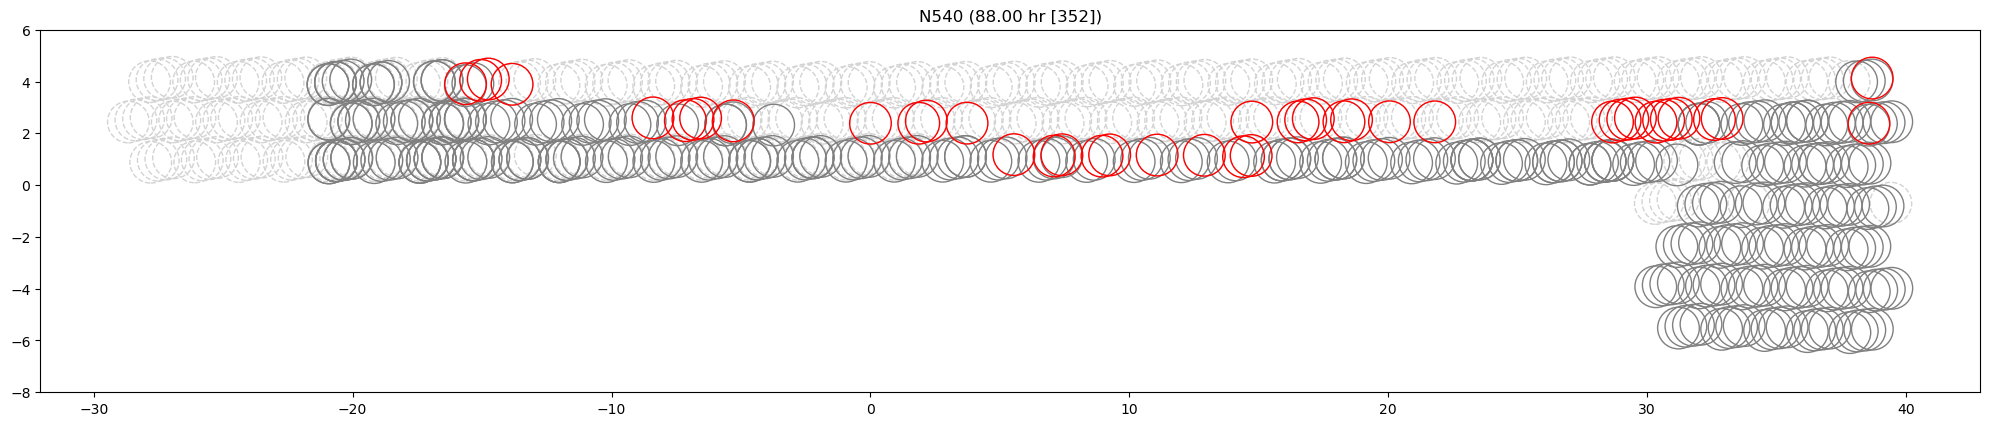

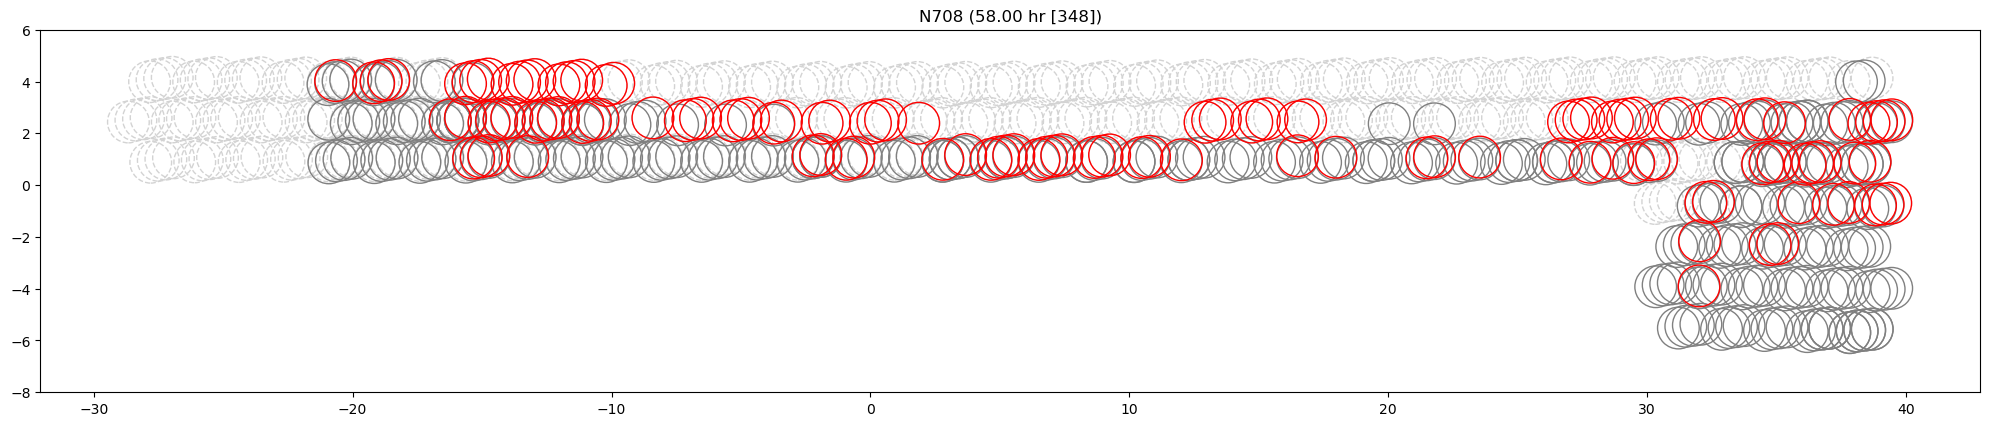

In [34]:
copilots = [coo_o, coo_h]
pointings_l = [oiii_pointings, halpha_pointings]
names = ['N540','N708']
exptimes = np.array([15.,10.])/60.
to_obs_l = [to_obs_oiii, to_obs_halpha]
wrap = lambda ra: np.where(ra > 300., ra - 360., ra )

for idx in range(2):
    copilot = copilots[idx]
    pointings = pointings_l[idx]
    name = names[idx]
    to_obs = to_obs_l[idx]
    
    fields = pointings['object'].str.extract(r'(.*?(?=_))')[0]
    observed = np.in1d(pointings.index, copilot.merian_sidecar['object'])
    #assert np.in1d(copilot.merian_sidecar['object'], pointings.index).all()

    fig = plt.figure(figsize=(20,4))
    ax = plt.subplot(111)
    ax.set_aspect('equal')
    
    nobs = (~observed).sum() 
    nhr = nobs * exptimes[idx]
    
    
    plt.scatter ( wrap(pointings.loc[~observed,'RA']), 
                 pointings.loc[~observed,'dec'], facecolor='None', edgecolor='lightgrey', ls='--', s=30**2)
    plt.scatter ( wrap(copilot.merian_sidecar['racenter']), 
                 copilot.merian_sidecar['deccenter'], 
                 facecolor='None', edgecolor='grey', s=30**2, ls='-' )


    #to_obs['odate'] = to_obs.apply(lambda x: x['qstamp'].split("_")[0], axis=1)
    plt.scatter ( wrap(pointings.reindex(to_obs.index)['RA']), 
                 pointings.reindex(to_obs.index)['dec'], 
                 facecolor='None', edgecolor='r', s=30**2, lw=1 )
    plt.title(f'{name} ({nhr:.2f} hr [{nobs}])')
    plt.tight_layout ()
    plt.ylim(-8,6)

In [ ]:
#is_queued = None
#oiii_emptyhours = []
#for idx in range(len(dates_oiii)):
#    night = dates_oiii[idx]
#    is_queued, emptyhours = sigjson_f2023b.plan_tomorrow( night[2], night[1], night[0], 
#                                             tele_fname, 
#                                             copilot_fname, 
#                                             slot = night[3],
#                                             mfilt='N540', 
#                                             is_queued=is_queued, 
#                                             pad_last_hour=False, 
#                                             maxairmass=1.8, 
#                                             save=False, 
#                                             verbose=False)
#    oiii_emptyhours.extend ( emptyhours )
#to_obs_oiii = is_queued.loc[~is_queued['qstamp'].isna()]
#
#is_queued = None
#halpha_emptyhours = []
#for idx in range(len(dates_halpha)):
#    night = dates_halpha[idx]
#    is_queued, emptyhours = sigjson_f2023b.plan_tomorrow( night[2], night[1], night[0], 
#                                             tele_fname, 
#                                             copilot_fname, 
#                                             slot = night[3],
#                                             mfilt='N708', 
#                                             is_queued=is_queued, 
#                                             pad_last_hour=False, 
#                                             maxairmass=1.8, 
#                                             save=False, 
#                                             verbose=False)
#    halpha_emptyhours.extend ( emptyhours )
#to_obs_halpha = is_queued.loc[~is_queued['qstamp'].isna()]

In [ ]:
is_queued = None
for idx in range(len(dates_halpha)):
    night = dates_halpha[idx]
    is_queued = sigjson_f2023b.plan_tomorrow( night[2], night[1], night[0], 
                                             tele_fname, 
                                             copilot_fname, 
                                             slot = night[3],
                                             mfilt='N708', 
                                             is_queued=is_queued, 
                                             pad_last_hour=False, 
                                             maxairmass=1.8, 
                                             save=False, 
                                             verbose=False)
    # \\ let's assume 15% efficiency loss due to overheads
    nstr =  f'{night[0]}{night[1]:02d}{night[2]+1}' 

    for name, row in is_queued.iterrows ():
        if isinstance(row['qstamp'],str):
            just_queued = nstr in row['qstamp']
            if just_queued:
                pull = np.random.randint(0,100)
                if pull <= 15:
                    is_queued.loc[name, 'is_queued'] = False
                    is_queued.loc[name, 'qstamp'] = np.NaN
to_obs_halpha = is_queued.loc[~is_queued['qstamp'].isna()]

In [ ]:
is_queued = None
for idx in range(len(dates_oiii)):
    night = dates_oiii[idx]
    is_queued = sigjson_f2023b.plan_tomorrow( night[2], night[1], night[0], 
                                             tele_fname, 
                                             copilot_fname, 
                                             slot = night[3],
                                             mfilt='N540', 
                                             is_queued=is_queued, 
                                             pad_last_hour=False, 
                                             maxairmass=1.8, 
                                             save=False, 
                                             verbose=False)
    # \\ let's assume 15% efficiency loss due to overheads
    nstr =  f'{night[0]}{night[1]:02d}{night[2]+1}' 

    for name, row in is_queued.iterrows ():
        if isinstance(row['qstamp'],str):
            just_queued = nstr in row['qstamp']
            if just_queued:
                pull = np.random.randint(0,100)
                if pull <= 15:
                    is_queued.loc[name, 'is_queued'] = False
                    is_queued.loc[name, 'qstamp'] = np.NaN
to_obs_oiii = is_queued.loc[~is_queued['qstamp'].isna()]

In [ ]:
copilots = [coo_o, coo_h]
pointings_l = [oiii_pointings, halpha_pointings]
names = ['N540','N708']
exptimes = np.array([15.,10.])/60.
to_obs_l = [to_obs_oiii, to_obs_halpha]

fig,axarr = plt.subplots(2,1,figsize=(20,5))
#ax = plt.subplot(111)
for idx in range(2):
    ax = axarr[idx]
    copilot = copilots[idx]
    pointings = pointings_l[idx]
    name = names[idx]
    to_obs = to_obs_l[idx]
    
    fields = pointings['object'].str.extract(r'(.*?(?=_))')[0]
    observed = np.in1d(pointings.index, copilot.merian_sidecar['object'])
    assert np.in1d(copilot.merian_sidecar['object'], pointings.index).all()


    ax.set_aspect('equal')
    
    nobs = (~observed).sum() 
    nhr = nobs * exptimes[idx]
    
    
    ax.scatter ( pointings.loc[~observed,'RA'], pointings.loc[~observed,'dec'], facecolor='None', edgecolor='lightgrey', ls='--', s=30**2)
    ax.scatter ( copilot.merian_sidecar['racenter'], copilot.merian_sidecar['deccenter'], 
                 facecolor='None', edgecolor='grey', s=30**2, ls='-' )


    #to_obs['odate'] = to_obs.apply(lambda x: x['qstamp'].split("_")[0], axis=1)
    ax.scatter ( pointings.reindex(to_obs.index)['RA'], pointings.reindex(to_obs.index)['dec'], 
                 facecolor='None', edgecolor='r', s=30**2, lw=1 )
    ax.set_title(f'{name} ({nhr:.2f} hr [{nobs} pointings]) to be covered')
    ax.set_ylim(-4,6)
plt.tight_layout ()
plt.savefig('/Users/kadofong/Downloads/S2023A_perfectweather_prediction.png')

In [ ]:
from skipper import observe
from scipy import interpolate
from scipy import optimize
from astropy import time